## Подключение библиотек ##

In [37]:
import time
import numpy as np
import torch
import warnings
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.special import gamma, erfc
from scipy.integrate import quad
from sklearn.metrics import mean_absolute_error
from pyfod.fod import caputo
from functools import partial
import matplotlib.pyplot as plt
from mittag_leffler import ml
%matplotlib inline

## Настройка СUDA ##  

In [38]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cpu')

## Функция Миттаг-Леффлера ##

In [39]:
def MLF(z, alpha, N=10000):
    # Преобразование типов данных
    if not isinstance(z, np.ndarray):
        if isinstance(z, torch.Tensor):
            z = z.numpy()
        else:
            z = np.array(z)
    z = np.atleast_1d(z)
    
    # Случаи для различных параметров alpha
    if alpha == 0:
        return 1/(1 - z)
    elif alpha == 1:
        return np.exp(z)
    elif alpha == 1/2:
        return np.exp(z ** 2) * erfc(-z)
    elif alpha > 1 or all(z > 0):
        k = np.arange(N)
        return np.polynomial.polynomial.polyval(z, 1 / gamma(alpha * k + 1))
        # j = np.arange(N).reshape(-1, 1)
        # E = (np.power(z, j)) / gamma(alpha * j + 1)
        # return torch.tensor(np.sum(E, axis=0))

    def _MLF(z, alpha):
        if z < 0:
            # def f(x): return ((np.exp(-x * (-z)**(1 / alpha)) * x**(alpha - 1) * np.sin(np.pi * alpha))
            #                   / (x**(2 * alpha) + 2 * x**alpha * np.cos(np.pi * alpha) + 1))
            def f(x): return ((np.exp(-x * np.power(-z, 1 / alpha)) * np.power(x, alpha - 1) * np.sin(np.pi * alpha))
                    / (np.power(x, 2 * alpha) + 2 * np.power(x, alpha) * np.cos(np.pi * alpha) + 1))
            return 1 / np.pi * quad(f, 0, np.inf)[0]
        elif z == 0:
            return 1
        else:
            return MLF(z, alpha)
        
    return np.vectorize(_MLF)(z, alpha)


res = MLF(1, 1)
print(f"MLF = {res}, type={type(res)}")


MLF = [2.71828183], type=<class 'numpy.ndarray'>


In [40]:
# def MLF(z, alpha, N=1000):
#     # tic = time.perf_counter()
#     if not isinstance(z, torch.Tensor):
#         if isinstance(z, np.ndarray):
#             z = torch.from_numpy(z, dtype = torch.float64)
#         else:
#             z = torch.tensor([z], dtype = torch.float64)
#     else:
#         z = z.type(torch.float64)
#     result = torch.zeros(len(z))
#     for j in range(N):
#         result += torch.pow(z, j) / gamma(alpha * j + 1)
#     # toc = time.perf_counter()
#     # print(f"Time = {toc-tic}")
#     return result

# res = MLF(0, 1)
# print(f"MLF = {res}, type={type(res)}")


In [41]:
%%script echo skipping
x = np.linspace(-10, 1, 100)
plt.grid()
for i in range(1, 11):
    plt.plot(x, MLF(x, i/10), label="alpha = "+str(i/10))
plt.legend()
plt.ylim(-2, 5)
plt.xlim(x[0], x[-1])

Couldn't find program: 'echo'


In [42]:
%%script echo skipping
x = np.linspace(-10, 1, 100)
plt.grid()
plt.plot(x, MLF(x, 0.1), label="alpha = 0.1")
plt.legend()
plt.ylim(-2, 5)
plt.xlim(x[0], x[-1])

Couldn't find program: 'echo'


## Модель нейронной сети ##

In [43]:
class Net(nn.Module):
    def __init__(self, num_hidden, size_hidden, activation=nn.Tanh()):
        super(Net, self).__init__()
        self.activation_function = activation

        self.layer_input = nn.Linear(2, size_hidden).double()
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(size_hidden, size_hidden).double() for _ in range(num_hidden - 1)])
        self.layer_output = nn.Linear(size_hidden, 1).double()
    
    def forward(self, x, p):
        x = x.reshape(-1, 1)
        x = x.type(torch.double)
        p = p.type(torch.double)
        if p.shape == torch.Size([1]):
            x  = x.reshape(-1,)
            x_p = torch.cat([x, p])
        else: 
            x_p = torch.cat([x, p], dim=1)
        x_p = self.layer_input(x_p)
        x_p = self.activation_function(x_p)
        for layer in self.hidden_layers:
            x_p = layer(x_p)
            x_p = self.activation_function(x_p)
        output = self.layer_output(x_p)
        output = output.type(torch.float64)
        return output


### Инициализация весов ###

In [44]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

### Текущий результат работы сети ###

In [45]:
def net_fn(nn, x, p):
    return nn(x, p)

### Вычисление производной ###

In [46]:
def df(nn, alpha, x, p):
    def f(x, p=None):
        x = torch.from_numpy(x)
        tmp = torch.full((len(x), 1), p.item())
        return net_fn(nn, x, tmp)
    result = torch.zeros((len(x), 1))
    x = torch.unique(x)
    p = torch.unique(p)
    for i in range(len(x)):
        for j in range(len(p)):
            foo = partial(f, p=p[j])
            fd = caputo(f=foo, alpha=alpha, lower=0, upper=x[i], quadrature='rs', n=1000)
            result[i * len(p) + j] = fd['fd']

    return result


### Функция ошибки ###

In [47]:
def loss_function(nn, alpha, lin, x=None, p=None, additional_condition=None, verbose=False):
    mse_loss = torch.nn.MSELoss()
    interior_loss = 0.

    if lin == "Linear":
        lmbd = additional_condition
        # Начальное условие
        x_init = torch.zeros_like(p)
        
        initial_loss = net_fn(nn, x_init, p) - p
        initial_loss = mse_loss(initial_loss, torch.zeros_like(initial_loss))
        
        # Внутренняя ошибка
        grid = torch.meshgrid(x[1:].reshape(-1,), p.reshape(-1,), indexing='ij')
        x_grid = grid[0].flatten().reshape(-1, 1)
        p_grid = grid[1].flatten().reshape(-1, 1)
        lmbd_tmp = torch.full((len(x_grid), 1), lmbd)
        
        interior_loss = df(nn, alpha, x_grid, p_grid) - lmbd_tmp * net_fn(nn, x_grid, p_grid)
        interior_loss = mse_loss(interior_loss, torch.zeros_like(interior_loss)) 
        
    elif lin == "Nonlinear":
        lmbd = additional_condition
        # Начальное условие
        x_init = torch.zeros_like(p)
        
        initial_loss = net_fn(nn, x_init, p) - x_init
        initial_loss = mse_loss(initial_loss, torch.zeros_like(initial_loss))
        
        # Внутренняя ошибка
        grid = torch.meshgrid(x[1:].reshape(-1,), p.reshape(-1,), indexing='ij')
        x_grid = grid[0].flatten().reshape(-1, 1)
        p_grid = grid[1].flatten().reshape(-1, 1)
        
        interior_loss = df(nn, alpha, x_grid, p_grid) - lmbd * torch.pow(torch.abs(net_fn(nn, x_grid, p_grid)), p_grid)
        interior_loss = mse_loss(interior_loss, torch.zeros_like(interior_loss)) 
        
    # print(f"Initial loss: {initial_loss}")
    # print(f"Interior loss: {interior_loss}")

    loss = initial_loss + interior_loss     
    return loss

### Цикл обучения ###

In [48]:
def training_loop(nn, alpha, loss_fn, optimizer, scheduler=None, n_epochs=1000):
    train_loss = torch.zeros(n_epochs)
    
    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        loss = loss_fn(nn, alpha)
        if loss.requires_grad:
            loss.backward()
        return loss
    
    for epoch in range(1, n_epochs + 1):
                       
        if isinstance(optimizer, torch.optim.LBFGS):
            optimizer.step(closure)
            loss = closure()
        else:
            loss = loss_fn(nn, alpha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            
        if scheduler is not None:
            scheduler.step(loss)
            
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, learning rate = {optimizer.param_groups[-1]['lr']}, loss={loss},\n")

        if torch.isnan(loss):
            break        
    return nn, train_loss      


## Параметры задач ##

#### Точные решения ####

In [49]:
def solution_lin(x, alpha, y0_lin, lambda_lin):
    solution = y0_lin * ml(lambda_lin * np.power(x, alpha), alpha)
    return solution

def solution_nonlin(x, alpha, m_nonlin, lambda_nonlin):
    gm = alpha / (1 - m_nonlin)
    tmp = gamma(gm + 1) / (lambda_nonlin * gamma(gm - alpha + 1))
    B = np.power(tmp, 1 / (m_nonlin - 1))
    solution = B * np.power(x, gm)
    return solution

In [50]:
Equations = {"Linear" : solution_lin, "Nonlinear" : solution_nonlin}


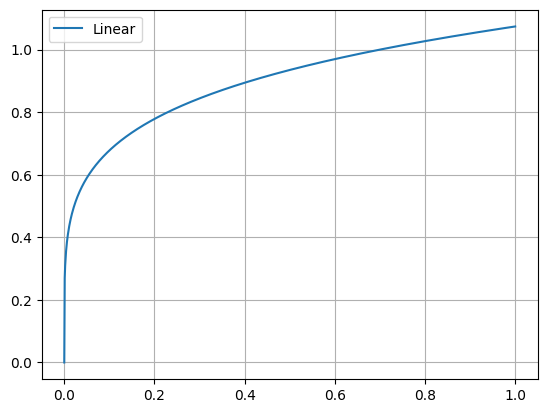

In [51]:
x = torch.linspace(0, 1, 1000)
plt.grid()
# plt.plot(x, Equations['Linear'](x, alpha=0.1, y0_lin=0.5, lambda_lin=0.9))
plt.plot(x, Equations['Nonlinear'](x, alpha=0.1, m_nonlin=0.5, lambda_nonlin=1))
plt.legend(Equations.keys())

## Обучение сети ##

### Гиперпараметры сети ###

In [52]:
problem = 'Nonlinear'
cond = 0.5
alpha = 0.1

num_hidden = 2
size_hidden = 20
activation_function = nn.Tanh()

NN = Net(num_hidden, size_hidden, activation_function)
NN.apply(init_weights)

learning_rate_Adam = 0.01
learning_rate_LBFGS = 0.01
epochs_Adam = 40000
epochs_LBFGS = 1000

optimizer_adam = torch.optim.AdamW(NN.parameters(), lr=learning_rate_Adam, weight_decay=0.00001) # , weight_decay=0.00001
optimizer_lbfgs = torch.optim.LBFGS(NN.parameters(), lr=learning_rate_LBFGS)
scheduler = ReduceLROnPlateau(optimizer_adam, 'min', factor=0.1, patience=4000, min_lr=1e-6)


### Тренировка на заданном интервале ###

In [53]:
x = torch.linspace(0, 1, 40).reshape(-1, 1)
p = torch.linspace(0.1, 0.9, 9).reshape(-1, 1)


In [54]:
loss_fn = partial(loss_function, lin=problem, x=x, p=p, additional_condition=cond, verbose=True)
PINN_Adam, train_loss_Adam = training_loop(
    nn=NN,
    alpha=alpha,
    loss_fn=loss_fn,
    optimizer=optimizer_adam,
    scheduler=scheduler,
    n_epochs=epochs_Adam
)


Epoch 100, learning rate = 0.01, loss=0.004141540222739048,

Epoch 200, learning rate = 0.01, loss=0.0018491627398418635,

Epoch 300, learning rate = 0.01, loss=0.0013414181344762934,

Epoch 400, learning rate = 0.01, loss=0.0010488934747772457,

Epoch 500, learning rate = 0.01, loss=0.0009120660563739232,

Epoch 600, learning rate = 0.01, loss=0.0007966601944780778,

Epoch 700, learning rate = 0.01, loss=0.0006897425385415523,

Epoch 800, learning rate = 0.01, loss=0.0005934492792936157,

Epoch 900, learning rate = 0.01, loss=0.0005078599502825327,

Epoch 1000, learning rate = 0.01, loss=0.0004319310924006906,

Epoch 1100, learning rate = 0.01, loss=0.0003690237669143758,

Epoch 1200, learning rate = 0.01, loss=0.00034760292423094354,

Epoch 1300, learning rate = 0.01, loss=0.0002837809420663107,

Epoch 1400, learning rate = 0.01, loss=0.0002717130827275039,

Epoch 1500, learning rate = 0.01, loss=0.0004351153687559516,

Epoch 1600, learning rate = 0.01, loss=0.00015270103386687633,



In [55]:
torch.save(PINN_Adam, f"{problem}_param_m_40_9_alpha_0.1.pth")

In [56]:
# PINN = PINN_Adam
# x_eval = torch.linspace(0, 1, 1000).reshape(-1, 1)
# if problem == 'Linear':
#     y0 = 2
#     cond_eval = torch.full(x_eval.shape, y0)
#     nn_approx = PINN(x_eval, cond_eval).detach().numpy()
#     sol = Equations[problem](x_eval, alpha, y0_lin=y0, lambda_lin=cond)
# elif problem == 'Nonlinear':
#     lmbd = 0.8
#     cond_eval = torch.full(x_eval.shape, lmbd)
#     nn_approx = PINN(x_eval, cond_eval).detach().numpy()
#     sol = Equations[problem](x_eval, alpha, m_nonlin=cond, lambda_nonlin=lmbd)

### Оценка качества модели ###

In [57]:
def error(solution, approximation):
    if isinstance(solution, torch.Tensor):
        solution = solution.detach().numpy()
    if np.any(np.isnan(approximation)):
        return np.nan, np.nan, np.nan
    MAE = mean_absolute_error(solution[1:], approximation[1:])
    MRE = np.mean(np.fabs(approximation[1:] - solution[1:]) / np.fabs(solution[1:])) * 100
    InitLoss = float(np.fabs(solution[0] - approximation[0]))
    # print(f"Mean absolute error (MAE) = {MAE:.5f}\nMean relative error (MRE) = {MRE:.5f}%\nLoss on initial condition = {InitLoss:.5f}")
    return MAE, MRE, InitLoss

# MAE, MRE, InitLoss = error(sol, nn_approx)

### Отрисовка графиков ###

In [58]:
def plot_graph(x, solution, approximation, name=None):
    plt.figure(figsize=(6, 6))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-0.1, 1.1)
    
    plt.plot(x, approximation, '-.', label='PINN')
    plt.plot(x, solution, label='Solution')
    plt.grid()
    plt.legend()
    
    MAE, MRE, InitLoss = error(solution, approximation)
    plt.title(f"Mean absolute error (MAE) = {MAE:.5}\nLoss on initial condition = {InitLoss:.5}")
    
    if name is not None:
        plt.savefig(f"{name}.png")
    
    # plt.cla()
    return MAE, MRE, InitLoss

  
# plot_graph(x_eval, sol, nn_approx)

In [59]:
# alpha = 0.99
# PINN_Adam = torch.load('Linear_param_initcond_20_11_alpha_0.99.pth')

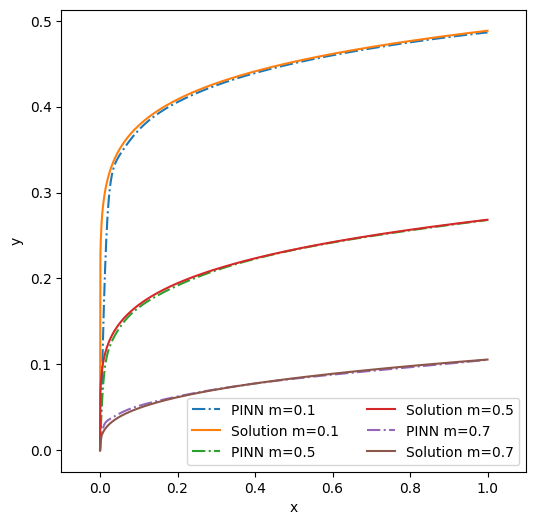

In [82]:
PINN = PINN_Adam
plt.figure(figsize=(6, 6))
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.1, 1.1)
x_eval = torch.linspace(0, 1, 1000).reshape(-1, 1)
# for l in [1, 1.2, 1.4, 1.6, 1.8, 2]:
#     y_0 = l
#     cond_eval = torch.full(x_eval.shape, y_0)
#     nn_approx = PINN(x_eval, cond_eval).detach().numpy()
#     sol = Equations[problem](x_eval, alpha, y0_lin=y_0, lambda_lin=cond)
#     plt.plot(x_eval, nn_approx, '-.', label=f'PINN y0={y_0}')
#     plt.plot(x_eval, sol, label=f'Solution y0={y_0}')
#     plt.grid()
#     plt.legend(ncols=2) # ncols=2, loc='upper left'
# plt.grid()
for l in [0.1, 0.5, 0.7]:
    m = l
    cond_eval = torch.full(x_eval.shape, m)
    nn_approx = PINN(x_eval, cond_eval).detach().numpy()
    sol = Equations[problem](x_eval, alpha, m_nonlin=m, lambda_nonlin=cond)
    plt.plot(x_eval, nn_approx, '-.', label=f'PINN m={m}')
    plt.plot(x_eval, sol, label=f'Solution m={m}')
    plt.grid()
    plt.legend(ncols=2) # ncols=2, loc='upper left'
plt.grid()